# Modeling battery with maximal charging power limit

In battery_v3 the power limitation is modelled with a piecewise linear function of the state of charge using 3 break points.
One can change the break point using 'pw_x' and 'pw_y', respectively the soc and the relative charging limits.
By default, 'pw_x'= [0.0, 50, 100], 'pw_y'= [1, 0.95, 0.1].

In order to cycle the battery, in this example, we are adding a square source (periodically charging and
discharging the battery) and a debug source to assure the power equilibrium.

Results show the non linear limitation during charging phases.

In [1]:
import os

from pyomo.environ import *
from pyomo.dae import ContinuousSet, Integral

from lms2.electric.batteries import battery_v2, battery_v3
from lms2.electric.sources import square, debug_source
from lms2.core.horizon import SimpleHorizon
from lms2.tools.data_processing import read_data, load_data

## Optimization problem

In [2]:
# création de l'horizon d'étude
horizon = SimpleHorizon(tstart='2020-01-01 00:00:00', tend='2020-01-01 12:00:00', time_step='10 min')

The problem consist of a battery and a debug source. The source will be defined later. 

In [12]:
# création du problème d'optimisation
m = ConcreteModel()
m.time = ContinuousSet(initialize=[0, horizon.horizon.total_seconds()])

option_bat = {'time': m.time, 'c_bat': 100, 'eta_c': 0.9, 'eta_d': 0.9,
              'p_max': 10, 'p_min': 10, 'soc_min': 10, 'soc_max': 95,
              'pw_x': [0.0, 50, 100], 'pw_y': [1, 0.95, 0.1]}
option_deb = {'time': m.time, 'p_min': -10}

m.bat = Block(rule=lambda x: battery_v3(x, **option_bat))
m.deb = Block(rule=lambda x: debug_source(x, **option_deb))

## Discretization every 10min

In [13]:
# discrétisation temporelle
from pyomo.environ import TransformationFactory
TransformationFactory('dae.finite_difference').apply_to(m, nfe=horizon.nfe)

### Definition of the source. 
This is a square signal of amplitude pM and period is the number of time steps during the period. In this example, 60 time steps of 10 min each represent a period of 10 hours. 

In [14]:
pM = 10
dt = 600
period = 60


def initial(b, t):
    if (t // dt) % period < period / 2:
        return pM
    else:
        return -pM


m.ps = Param(m.time, default=initial)

In [6]:
# 
@m.Constraint(m.time)
def bilan_puissance(b, t):
    return b.bat.p[t] + b.deb.p[t] + b.ps[t] == 0


@m.Objective()
def cout(b):
    return sum([b.deb.abs_p[t] for t in b.time])

m.bat._soc_final.deactivate()

In [7]:
# solver
#sol = SolverFactory('gurobi', solver_io="direct")
sol = SolverFactory('glpk')
res = sol.solve(m)

## Post-processing

    (deprecated in 6.0) (called from /tmp/ipykernel_10754/3759490625.py:6)


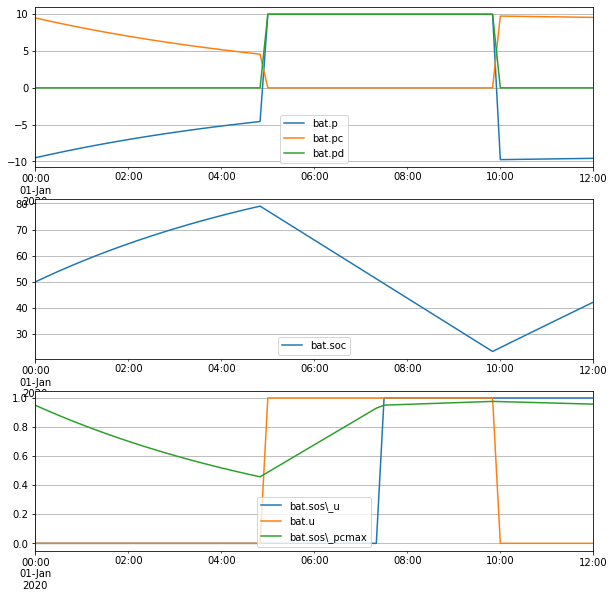

In [8]:
import matplotlib.pyplot as plt
from lms2.tools.post_processing import *

fig, ax = plt.subplots(nrows=3, figsize=(10, 10))
pplot(m.bat.p, m.bat.pc, m.bat.pd, index=horizon.current, ax= ax[0], fig=fig)
pplot(m.bat.soc, index=horizon.current, ax=ax[1], fig=fig)
pplot(m.bat.sos_u, m.bat.u, m.bat.sos_pcmax, index=horizon.current, ax=ax[2], fig=fig)

plt.show()

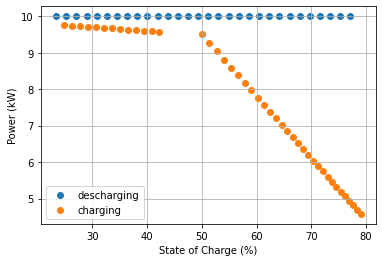

In [11]:
pd = Series({i: v() for i, v in m.bat.pd.items()})
soc = Series({i: v() for i, v in m.bat.soc.items()})
pc = Series({i: v() for i, v in m.bat.pc.items()})

fig = plt.figure()
plt.scatter(soc[pd!=0], pd[pd!=0], label='descharging')
plt.scatter(soc[pc!=0], pc[pc!=0], label='charging')
plt.legend()
plt.xlabel('State of Charge (%)')
plt.ylabel('Power (kW)')
plt.grid()